# Seminar: Gradient Boosting
Course: Machine Learning by professor Evgeny Burnaev
<br>
Author: Andrey Lange

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

## Example 1: Gradient Boosting for regression

In [2]:
def get_dataset_1d():
    # prepare dataset
    n = 1                      # number of features
    N = 100**n                 # number of samples
    np.random.seed(0)
    X = np.random.random((N, n))*3
    coeffs = 1 +  2 * np.random.random((n, 1))
    y = np.sin(np.matmul(X*X, coeffs)) + np.random.random((N, 1))/3
    y = y.ravel()
    
    return (X, y)
    
def plot_results(X, y, y_pred, title=''):
    plt.plot(X, y, '*b')
    plt.plot(X, y_pred, '.r')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('y')
    plt.show()


---

### Question 1.
In the following example a Gradient Boosting regression is performed by only 1 tree and very small shrinkage `nu=1e-10`. The solution looks like a constant.

1.1. Why it looks like a constant?
<br>
1.2. Try to find that constant value taking into account that `loss='ls'` and draw it on the same plot.

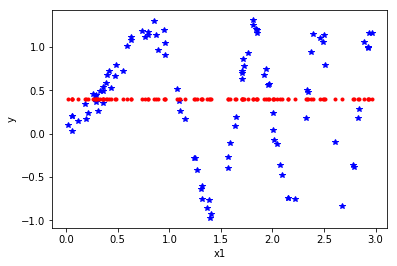

In [3]:
X, y = get_dataset_1d()

clf = GradientBoostingRegressor(loss='ls', max_depth=1, learning_rate=1e-10, n_estimators=1)
clf.fit(X, y)
y_pred = clf.predict(X)
plot_results(X, y, y_pred)

### Solution 1.
1.1. In case of only 1 tree the final boosting is
$$f_1(x) = f_0(x)+\nu \sum\limits_{j=1}^{J} \gamma_j I(x\in R_j).$$
Since $\nu$ is too small, $f_1(x)\approx f_0(x)$ and $f_0(x)$ is the initialization value
$$f_0(x) = {\rm argmin}_{\gamma} \sum_{i=1}^{N} L(y, \gamma).$$

1.2.
For the loss function $L(y, \gamma) = (y - \gamma)^2/2$ it is the mean of targets:
$$ f_0(x) = \frac{1}{N}\sum_{i=1}^N y_i.$$
You can add 
```
plt.plot(X, [np.mean(y)]*len(y), 'ok')
```
before `plot_results()` call.


---

### Question 2. 
Solve above question for `loss='lad'`.

### Solution 2. 
Change `np.mean()` for `np.median()`.


---

### Question 3. 
Some managers of industrial Data Science projects said me that each tree in Gradient Boosting is fit to the targets that are simply the differences $y_i-f_{m-1}(x_i)$ between the values $y_i$ and the current approximation $f_{m-1}(x_i)$ found on the previous step $m-1$. When is it correct?

### Solution 3.
It is true in case of Gradient Boosting for regression with the squared error loss 
$$L(y_i, f(x_i)) = \frac{1}{2}[y_i-f(x_i)]^2.$$


The gradients
$$ r_{im} = - \left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}\right]_{f=f_{m-1}}$$
are calculated for each data point $(x_i, y_i)$ on every step $m$. Then a regression tree is fit to the targets $r_{im}$. For the squared error loss the negative gradient is exactly the difference 
$$r_{im} = y_i-f_{m-1}(x_i).$$


---

### Question 4*. 
Actually, the managers from the question above said not only to what the trees are fit but also that the current solution is updated by simply adding each new tree multiplied by a shrinkage parameter and ignore any sophisticated math! :[]

The following code shows 2 ways of using the Gradient Boosting for regression:
1. Using the class `GradientBoostingRegressor()` - as it should be done if you use scikit-learn
2. Our own implementation by adding a tree step by step with shrinkage

Ensure that the pictures are the same no matter how you change the hyperparameters `max_depth`, `n_estimators` and `nu`!

In our implementation we fit each tree to the targets $y_i-f_{m-1}(x_i)$ (if you answered on the above question you know that it is correct here) multiply by shrinkage $\nu$ and add to the current model. But it seems that something is missing in our code. No matter how exactly the Gradient Boosting is implemented in scikit-learn, there are many slightly different variants. Assume that it is as described here https://scikit-learn.org/stable/modules/ensemble.html#mathematical-formulation, where the steepest descent chooses the optimal step length
$$
\gamma_m = \arg\min_{\gamma} \sum_{i=1}^{n} 
L
\left(
y_i, f_{m-1}(x_i)
- \gamma \nabla_F L(y_i, f_{m-1}(x_i))
\right),
$$
which is used for the model update
$$
f_m(x) = f_{m-1}(x) - \gamma_m \sum_{i=1}^{n} \nabla_F L(y_i, f_{m-1}(x_i)).
$$
But we did not implement it! Justify the correctness of our easy implementation of GB.

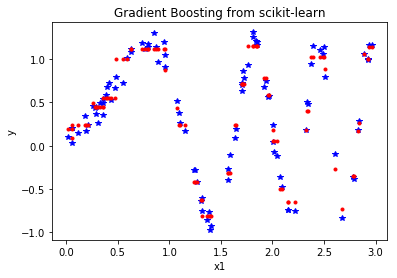

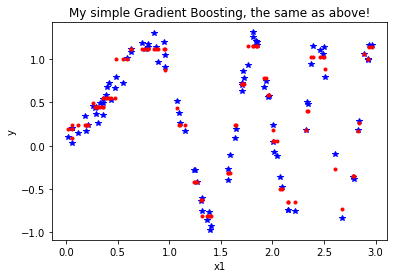

In [4]:
X, y = get_dataset_1d()

max_depth = 3
n_estimators = 6
nu = 0.8                            # shrinkage

# usual Gradient Boosting call
clf = GradientBoostingRegressor(loss='ls', max_depth=max_depth, learning_rate=nu, n_estimators=n_estimators)
clf.fit(X, y)
f = clf.predict(X)
plot_results(X, y, f, 'Gradient Boosting from scikit-learn')

# my Gradient Boosting implementation
clf = DecisionTreeRegressor(max_depth=max_depth)
f = np.mean(y)                      # initialization
for m in range(1, n_estimators+1):
    f = f + clf.fit(X, y - f).predict(X) * nu # fit to the difference and shrink
plot_results(X, y, f, 'My simple Gradient Boosting, the same as above!')

### Solution 4*.

For the squared error loss $L(y_i, f(x_i)) = \frac{1}{2}[y_i-f(x_i)]^2$ we have
$$ L\left(y_i, f_{m-1}(x_i) - \gamma \nabla_F L(y_i, f_{m-1}(x_i))\right) =
 \frac{1}{2} (1 - \gamma)^2 (y_i - f_{m-1}(x_i))^2,
$$
and thus $\gamma_m=1$ or in other words we can skip the steepest descent in this case.

## Example 2: Gradient Boosting for classification, CatBoost.

Lets consider Titanic data! Below is yet another example of easy feature engineering, data preprocessing and the application of Gradient Boosting

In [5]:
## load data and some easy preprocessing, even Feature Engineering
# we use only training dataset because the Kaggle's testing one does not have class labels 
# and so we can not measure the model quality

X_train = pd.read_csv('train.csv')
y_train = X_train['Survived']
X_train = X_train.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], axis=1)

# take only the first letter from the Cabin number, which is maybe the ship level...
def keep_only_level_of_cabin(X):
    idx = X['Cabin'].notnull()
    X.loc[idx, 'Cabin'] = [s.strip()[0] for s in X['Cabin'][idx].values]
    return X

# CatBoost can not process categorical features with NaN, we set them to the string 'MISS'
def change_NaN_to_str(X, cat_features_cols):
    for col in cat_features_cols:
        idx = X[col].isnull()
        X.loc[idx, col] = 'MISS'
    return X

X_train = keep_only_level_of_cabin(X_train)
X_train = change_NaN_to_str(X_train, ['Sex', 'Cabin', 'Embarked'])

In [6]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,MISS,S
1,1,female,38.0,1,0,71.2833,C,C
2,3,female,26.0,0,0,7.9250,MISS,S
3,1,female,35.0,1,0,53.1000,C,S
4,3,male,35.0,0,0,8.0500,MISS,S
5,3,male,NaN,0,0,8.4583,MISS,Q
6,1,male,54.0,0,0,51.8625,E,S
7,3,male,2.0,3,1,21.0750,MISS,S
8,3,female,27.0,0,2,11.1333,MISS,S
9,2,female,14.0,1,0,30.0708,MISS,C


### Note: 

  1. We use categorical features and CatBoost processes it ok.

  
  2. Below you can see the tuning of CatBoost with cross-validation, you can play with the hyperparameter ranges.
  
  
  3. You can "unnatural disable" cross-validation and ensure that the best score increases (although it is impractical because of overfitting).
  
  
  4. CatBoost processes contineous feature 'Age' despite there are NaNs. It is easy for trees - we can, say, just ignore these values.
  
  
  5. We preprocess the 'Cabin' feature so that it has only the level ('C', 'E', ...). 
  This is so that there would not be a large number of unique noninformative values. And here we process NaNs as special 'MISS' value because it may mean not the incompletness in the data, but that no any proper value can be for some samples (it is highly correlated with 'Pclass' feature).  
  
  
  6. You can play with feature importances: drop the most important feature and check how the accuracy and the roc_auc reduce. Do the same with the least important feature and feel who affects more. 

In [8]:
!pip install catboost

best accuracy score: 0.8215488215488216


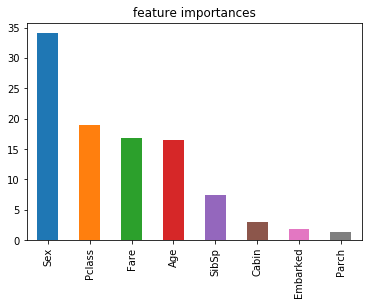

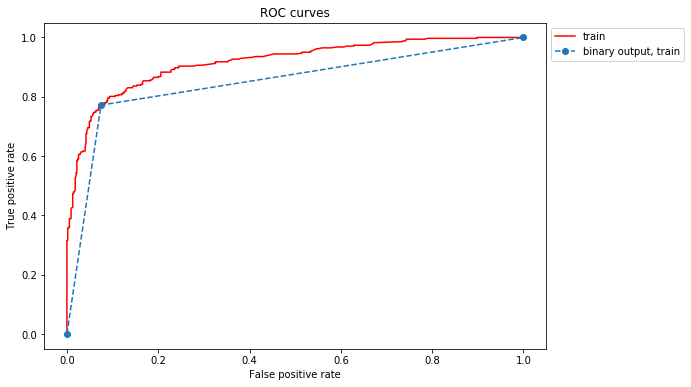

In [9]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

clf = CatBoostClassifier(loss_function = 'Logloss',
                         # categorical features processing: 
                         cat_features  = np.where(X_train.columns.isin(['Sex', 'Cabin', 'Embarked']))[0], 
                         verbose = 0)

clf = GridSearchCV(clf,
                   # you can play with tuning, up to your CPU performance:
                   {'max_depth': [1, 3, 5], 'n_estimators': [50, 150], 'learning_rate': [0.001, 0.01, 0.1, 1]},
                   # cross-validation prevents overfitting! you can disable it by setting 
                   # cv = [(np.array(range(len(y_train))), np.array(range(len(y_train))))]
                   cv = 3)
clf.fit(X_train, y_train)

print('best accuracy score:', clf.best_score_) # validation score

# feature importances
fi = pd.Series(clf.best_estimator_.feature_importances_, index=X_train.columns)
fi.sort_values(ascending=False).plot(kind='bar')
plt.title('feature importances')
plt.show()

# now let's draw different ROC curves
plt.figure(figsize=[9, 6])
fpr, tpr, _ = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, 'r', label='train')
fpr, tpr, _ = roc_curve(y_train, clf.predict(X_train))
plt.plot(fpr, tpr, '--o', label='binary output, train')
plt.legend(bbox_to_anchor=(0.999, 1))
plt.title('ROC curves')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

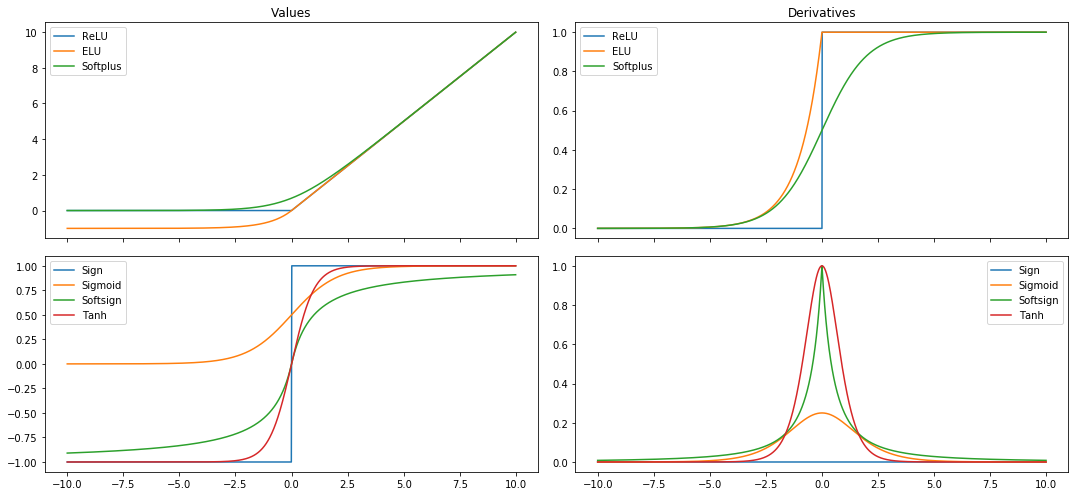

In [2]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch


x = torch.arange(-10, 10, .01, requires_grad=True)
x.sum().backward() # to create x.grad

f, axes = plt.subplots(2, 2, sharex=True, figsize=(15, 7))
axes[0, 0].set_title('Values')
axes[0, 1].set_title('Derivatives')

for i, function_set in (0, (('ReLU', F.relu), ('ELU', F.elu), ('Softplus', F.softplus))), \
                       (1, (('Sign', torch.sign), ('Sigmoid', torch.sigmoid), ('Softsign', F.softsign), ('Tanh', torch.tanh))):
    for function_name, activation in function_set:
        ### BEGIN Solution
        x.grad.zero_()
        xs = x.detach().numpy()
        function_values = activation(x).data.numpy()
        activation(x).sum().backward()
        derivative_values = x.grad.data.numpy()
        axes[i, 0].plot(xs, function_values, label = function_name)
        axes[i, 1].plot(xs, derivative_values , label=function_name)
        ### END Solution

    axes[i, 0].legend()
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]

input_size = 8*8
classes_n = 10

In [5]:
class Linear:
    def __init__(self, input_size, output_size):
        self.thetas = np.random.randn(input_size, output_size)
        self.thetas_grads = np.empty(self.thetas)
        self.bias = np.random.randn(output_size)
        self.bias_grads = np.empty(self.bias)


    def forward(self, x): 
        output = np.matmul(x, self.thetas) + self.bias
        return output
    

    def backward(self, x, output_grad):
        ### BEGIN Solution
        # ... calculate grads
        # self.thetas_grads += 
        # self.bias_grads += 
        ### END Solution
        return input_grad


class LogisticActivation:
    def forward(self, x):
        output = 1/(1 + np.exp(-x))
        return output


    def backward(self, x, output_grad):
        ### BEGIN Solution
        # ... calculate grads
        ### END Solution
        return input_grad
    

class SoftMaxActivation:
    def forward(self, x):
        output = np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)
        return output
    

    def backward(self, x, output_grad):
    def backward(inputs, gradient):
        softmax = SoftmaxLoss.softmax(inputs[0])
        return [
            gradient * (softmax - inputs[1]) / inputs[0].shape[0],
            gradient * (-np.log(softmax)) / inputs[0].shape[0]
        ]
        return input_grad
    

class MLP:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear(hidden_layer_size, output_size)
        
    
    def forward(self, x):
        return linear2.forward(activation1.forward(self.linear1.forward(x)))


    def backward(self, x, output_grad):
        ### BEGIN Solution
        # ... calculate and update grads
        ### END Solution

SyntaxError: unexpected EOF while parsing (<ipython-input-5-4073bb0cca9d>, line 63)

In [6]:
### BEGIN Solution
criterion = torch.nn.CrossEntropyLoss()
# Please, implement here everything else you need, like the loss function.
### END Solution

In [ ]:
np.random.seed(0)

mlp = MLP(input_size=input_size, hidden_layer_size=100, output_size=classes_n)

epochs_n = 200
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = digits_train
x_test = digits_test
y_train = targets_train
y_test = targets_test

learning_rate = 1e-3

for epoch in range(epochs_n):
    if epoch % 10 == 0:
        print('Starting epoch {}'.format(epoch), end=' ')
    for sample_i in range(train_size):
        x = x_train[sample_i]
        target = y_train[sample_i]

        ### BEGIN Solution
        # ... zero the gradients
        # prediction = mlp.forward(x)
        # loss = # use cross entropy loss
        # learning_curve[epoch] += loss
        # ... perform backward pass
        # ... update the weights simply with weight -= grad * learning_rate
    
    # learning_curve[epoch] /= train_size
    # prediction = mlp.forward(x_test)
    # loss = # use cross entropy loss
    # test_curve[epoch] = loss
    ### END Solution


plt.plot(learning_curve)
plt.plot(test_curve)